In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy.stats import ttest_rel
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# get raw data frame from csv
raw_data = pd.read_csv('/Users/erinburns/Library/CloudStorage/Box-Box/CoganLab/D_Data/GlobalLocal/combinedData.csv')

In [3]:
# add columns for previous trial accuracy and previous trial type
raw_data['prev_acc'] = raw_data.groupby('subject_ID')['acc'].shift(1)
raw_data['prev_cong'] = raw_data.groupby('subject_ID')['congruency'].shift(1)
raw_data['prev_sw'] = raw_data.groupby('subject_ID')['switchType'].shift(1)
raw_data['is_post_error'] = raw_data['prev_acc'] == 0

# removing subjects with low error counts from raw_data
error_counts = raw_data.groupby('subject_ID')['is_post_error'].sum()
subjects_to_remove = error_counts[error_counts < 30].index
raw_data = raw_data[~raw_data['subject_ID'].isin(subjects_to_remove)]

df = raw_data.copy()

In [24]:
# set up error dictionaries
post_iR_error_inc_correct = {
    'post_error': True,   
    'prev_cong': 'i',     
    'prev_sw': 'r',       
    'curr_cong': 'i',     
    'current_acc': 1      
}
post_iR_error_switch_correct = {
    'post_error': True,   
    'prev_cong': 'i',     
    'prev_sw': 'r',       
    'curr_sw': 's',     
    'current_acc': 1      
}
post_cS_error_switch_correct = {
    'post_error': True,   
    'prev_cong': 'c',     
    'prev_sw': 's',       
    'curr_sw': 's',     
    'current_acc': 1      
}
post_cS_error_inc_correct = {
    'post_error': True,   
    'prev_cong': 'c',     
    'prev_sw': 's',       
    'curr_cong': 'i',     
    'current_acc': 1      
}
post_error_inc_correct = {
    'post_error': True,
    'curr_cong': 'i',
    'current_acc': 1
}
post_error_con_correct = {
    'post_error': True,
    'curr_cong': 'c',
    'current_acc': 1
}
post_error_repeat_correct = {
    'post_error': True,
    'curr_sw': 'r',
    'current_acc': 1
}
post_error_switch_correct = {
    'post_error': True,
    'curr_sw': 's',
    'current_acc': 1
}
post_error_cS_correct = {
    'post_error': True,
    'curr_cong': 'c',
    'curr_sw': 's',
    'current_acc': 1
}
post_error_cR_correct = {
    'post_error': True,
    'curr_cong': 'c',
    'curr_sw': 'r',
    'current_acc': 1
}
post_error_iS_correct = {
    'post_error': True,
    'curr_cong': 'i',
    'curr_sw': 's',
    'current_acc': 1
}
post_error_iR_correct = {
    'post_error': True,
    'curr_cong': 'i',
    'curr_sw': 'r',
    'current_acc': 1
}


#correct dictionaries
post_iR_corr_inc_correct = {
    'post_error': False,   
    'prev_cong': 'i',     
    'prev_sw': 'r',       
    'curr_cong': 'i',     
    'current_acc': 1      
}
post_iR_corr_switch_correct = {
    'post_error': False,   
    'prev_cong': 'i',     
    'prev_sw': 'r',       
    'curr_sw': 's',     
    'current_acc': 1      
}
post_cS_corr_switch_correct = {
    'post_error': False,   
    'prev_cong': 'c',     
    'prev_sw': 's',       
    'curr_sw': 's',     
    'current_acc': 1      
}
post_cS_corr_inc_correct = {
    'post_error': False,   
    'prev_cong': 'c',     
    'prev_sw': 's',       
    'curr_cong': 'i',     
    'current_acc': 1      
}
post_corr_cS_correct = {
    'post_error': False,
    'curr_cong': 'c',
    'curr_sw': 's',
    'current_acc': 1
}
post_corr_cR_correct = {
    'post_error': False,
    'curr_cong': 'c',
    'curr_sw': 'r',
    'current_acc': 1
}
post_corr_iS_correct = {
    'post_error': False,
    'curr_cong': 'i',
    'curr_sw': 's',
    'current_acc': 1
}
post_corr_iR_correct = {
    'post_error': False,
    'curr_cong': 'i',
    'curr_sw': 'r',
    'current_acc': 1
}
post_corr_inc_correct = {
    'post_error': False,
    'curr_cong': 'i',
    'current_acc': 1
}
post_corr_con_correct = {
    'post_error': False,
    'curr_cong': 'c',
    'current_acc': 1
}
post_corr_repeat_correct = {
    'post_error': False,
    'curr_sw': 'r',
    'current_acc': 1
}
post_corr_switch_correct = {
    'post_error': False,
    'curr_sw': 's',
    'current_acc': 1
}

In [10]:
def get_subject_means(df, post_error=None, prev_cong=None, prev_sw=None, curr_cong=None, curr_sw=None, current_acc=1):
    """
    Filters data and returns mean RT per subject.
    post_error: True (post-error), False (post-correct), or None (both)
    prev_cong: 'i', 'c'
    prev_sw: 'r', 's', or None 
    curr_cong: 'i', 'c'
    curr_sw: 'r', 's', or None 
    current_acc: 1 (correct), 0 (incorrect)
    """
    mask = (df['RT'] > 0) # Base mask
    
    if post_error is not None:
        mask &= (df['is_post_error'] == post_error)
    if prev_cong is not None:
        mask &= (df['prev_cong'] == prev_cong)
    if prev_sw is not None:
        mask &= (df['prev_sw'] == prev_sw)
    if current_acc is not None:
        mask &= (df['acc'] == current_acc)

    if curr_cong is not None:
        mask &= (df['congruency'] == curr_cong)
    if curr_sw is not None:
        mask &= (df['switchType'] == curr_sw)
    if current_acc is not None:
        mask &= (df['acc'] == current_acc)


    stats = df[mask].groupby('subject_ID')['RT'].agg(['mean', 'count'])
    return stats

In [ ]:
def run_comparison(df, label1, label2, params1, params2):
    """
    params1 and params2 are dictionaries of the manual inputs we discussed.
    Example: params1 = {'post_error': True, 'curr_cong': 'i'}
    """
    # subject mean for both conditions
    res1 = get_subject_means(df, **params1)
    res2 = get_subject_means(df, **params2)
    
    # compare same subject
    comparison_df = pd.merge(res1, res2, on='subject_ID', suffixes=('_1', '_2'))

    final = comparison_df.dropna()
    
    #t-test
    t_stat, p_val = stats.ttest_rel(final['mean_1'], final['mean_2'])
    
    # print
    print(f"Comparison: {label1} vs {label2}")
    print(f"N Subjects: {len(final)}")
    print(f"Mean {label1}: {final['mean_1'].mean():.2f} ms")
    print(f"Mean {label2}: {final['mean_2'].mean():.2f} ms")
    print(f"t({len(final)-1}) = {t_stat:.3f}, p = {p_val:.4f}")
    
    return final

In [ ]:
# run 
# results1 = run_comparison(df, "post_iR_error_inc_correct", "post_iR_error_switch_correct", post_iR_error_inc_correct, post_iR_error_switch_correct)
# results2 = run_comparison(df, "post_cS_error_inc_correct", "post_cS_error_switch_correct", post_cS_error_inc_correct, post_cS_error_switch_correct)
# results3 = run_comparison(df, "post_iR_corr_inc_correct", "post_iR_corr_switch_correct", post_iR_corr_inc_correct, post_iR_corr_switch_correct)
# results4 = run_comparison(df, "post_cS_corr_inc_correct", "post_cS_corr_switch_correct", post_cS_corr_inc_correct, post_cS_corr_switch_correct)
# results5 = run_comparison(df, "post_error_inc_correct", "post_error_switch_correct", post_error_inc_correct, post_error_switch_correct)
# results6 = run_comparison(df, "post_error_inc_correct", "post_error_con_correct", post_error_inc_correct, post_error_con_correct)

TypeError: merge() got multiple values for argument 'on'

In [ ]:
# plotting code with stats

def plot_results(results_df, label1, label2, title):
    fig, ax = plt.subplots(figsize=(6, 8))

    # 1. Individual Subject Lines
    for i in results_df.index:
        ax.plot([0, 1], [results_df.loc[i, 'mean_1'], results_df.loc[i, 'mean_2']], 
                color='gray', alpha=0.3, linewidth=1.5, zorder=1)

    # 2. Individual Data Points
    ax.scatter([0]*len(results_df), results_df['mean_1'], color='tab:blue', s=120, alpha=0.6, zorder=2)
    ax.scatter([1]*len(results_df), results_df['mean_2'], color='tab:red', s=120, alpha=0.6, zorder=2)

    # 3. Group Mean + SEM
    means = [results_df['mean_1'].mean(), results_df['mean_2'].mean()]
    sems = [results_df['mean_1'].sem(), results_df['mean_2'].sem()]
    
    ax.errorbar([0, 1], means, yerr=sems, fmt='o-', color='black', 
                linewidth=5, markersize=16, capsize=12, zorder=3)

    # 4. Statistical Annotation
    t_stat, p_val = stats.ttest_rel(results_df['mean_1'], results_df['mean_2'])
    y_max = results_df[['mean_1', 'mean_2']].max().max()
    ax.text(0.5, y_max * 1.05, f"p = {p_val:.4f}", ha='center', fontweight='bold', fontsize=14)

    # 5. Styling
    ax.set_xticks([0, 1])
    ax.set_xticklabels([label1, label2], fontweight='bold', fontsize=14)
    ax.set_ylabel('Reaction Time (ms)', fontweight='bold', fontsize=14)
    ax.set_title(title, pad=30, fontweight='bold', fontsize=16)
    ax.set_xlim(-0.5, 1.5)
    
    # Simple Spine removal
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

inc                  1488.426318
con                  1355.268464
congruency_effect     170.309529
dtype: float64
sw             1504.187872
rep            1336.420588
switch_cost     187.383109
dtype: float64
Subjects for Congruency Effect: 17
Subjects for Switch Cost: 17


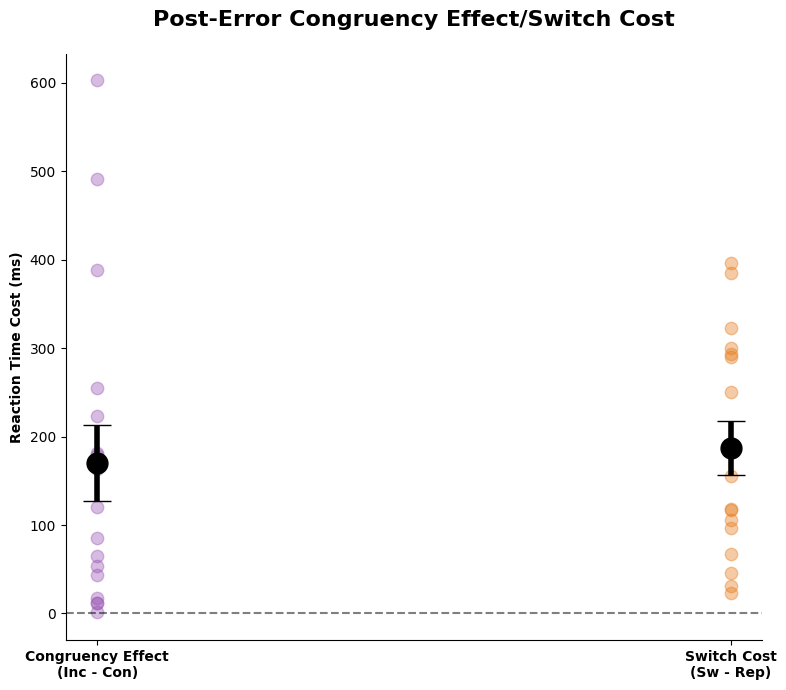

In [29]:
# plotting post-error congruency and switch costs

def plot_post_error_costs(df, inc_dict, con_dict, sw_dict, rep_dict):
    """
    Calculates and plots (Inc - Con) and (Switch - Repeat) after errors.
    """
    # 1. Get means for all 4 conditions
    res_inc = get_subject_means(df, **inc_dict)[['mean']].rename(columns={'mean': 'inc'})
    res_con = get_subject_means(df, **con_dict)[['mean']].rename(columns={'mean': 'con'})
    res_sw  = get_subject_means(df, **sw_dict)[['mean']].rename(columns={'mean': 'sw'})
    res_rep = get_subject_means(df, **rep_dict)[['mean']].rename(columns={'mean': 'rep'})

    # 2. Merge to find subjects with complete data
    # Conflict comparison
    conf_df = pd.merge(res_inc, res_con, on='subject_ID', how='inner')
    conf_df['congruency_effect'] = abs(conf_df['inc'] - conf_df['con'])
    print(conf_df.mean())
    
    # Switch comparison
    sw_df = pd.merge(res_sw, res_rep, on='subject_ID', how='inner')
    sw_df['switch_cost'] = abs(sw_df['sw'] - sw_df['rep'])
    print(sw_df.mean())

    # 3. Print N-counts
    print(f"Subjects for Congruency Effect: {len(conf_df)}")
    print(f"Subjects for Switch Cost: {len(sw_df)}")

    # 4. Setup Plot
    plt.figure(figsize=(8, 7))
    plt.axhline(0, color='black', linestyle='--', alpha=0.5) # Baseline (no cost)
    
    costs = [conf_df['congruency_effect'], sw_df['switch_cost']]
    labels = ['Congruency Effect\n(Inc - Con)', 'Switch Cost\n(Sw - Rep)']
    colors = ['#9b59b6', '#e67e22'] # Purple and Orange

    # 5. Plot individual subject points (Dots) and Group Means (Bars)
    for i, data in enumerate(costs):
        # Individual points
        x = [i] * len(data)
        plt.scatter(x, data, color=colors[i], alpha=0.4, s=80, label='_nolegend_')
        
        # Group Mean and SEM
        plt.errorbar(i, data.mean(), yerr=data.sem(), fmt='o', color='black', 
                     markersize=15, elinewidth=4, capsize=10, zorder=5)

    # Formatting
    plt.xticks([0, 1], labels, fontweight='bold')
    plt.ylabel('Reaction Time Cost (ms)', fontweight='bold')
    plt.title('Post-Error Congruency Effect/Switch Cost', pad=20, fontweight='bold', fontsize=16)
    
    ax = plt.gca(); ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# --- HOW TO RUN ---
# Define your 4 dictionaries first (ensure post_error=True in all)
plot_post_error_costs(df, post_error_inc_correct, post_error_con_correct, post_error_switch_correct, post_error_repeat_correct)
# plot_post_error_costs(df, post_corr_inc_correct, post_corr_con_correct, post_corr_switch_correct, post_corr_repeat_correct) 

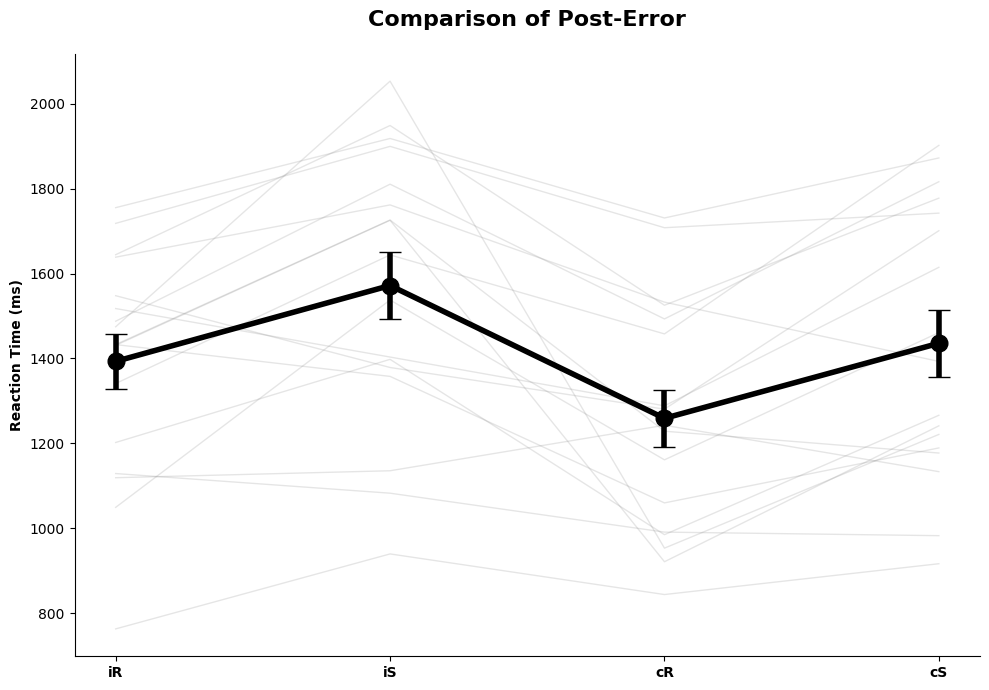

In [ ]:
# plot without stats and multiple conditions

def plot_four_way_comparison(df, dict_list, label_list, title="Behavioral Results"):
    """
    Plots four specific dictionary conditions on a single axis.
    """
    all_means = []
    for d in dict_list:
        res = get_subject_means(df, **d)
        # Drop 'count' and rename 'mean' immediately to avoid MergeErrors
        res = res[['mean']].copy() 
        all_means.append(res)

    # 2. merge
    for i in range(len(all_means)):
        all_means[i] = all_means[i].rename(columns={'mean': f'mean_{i}'})

    # Chain merges
    combined = all_means[0]
    for i in range(1, len(all_means)):
        combined = pd.merge(combined, all_means[i], on='subject_ID', how='inner')

    plt.figure(figsize=(10, 7))
    plt.style.use('seaborn-v0_8-muted')
    
    x_pos = range(len(dict_list))
    group_means = [combined[f'mean_{i}'].mean() for i in range(len(dict_list))]
    group_sems = [combined[f'mean_{i}'].sem() for i in range(len(dict_list))]

    for idx in combined.index:
        subject_data = [combined.loc[idx, f'mean_{i}'] for i in range(len(dict_list))]
        plt.plot(x_pos, subject_data, color='gray', alpha=0.2, linewidth=1, zorder=1)

    # error bars
    plt.errorbar(x_pos, group_means, yerr=group_sems, fmt='o-', color='black', 
                 linewidth=4, markersize=12, capsize=8, zorder=3, label='Group Mean')

    # Formatting
    plt.xticks(x_pos, label_list, fontweight='bold')
    plt.ylabel('Reaction Time (ms)', fontweight='bold')
    plt.title(title, pad=20, fontweight='bold', fontsize=16)
    
    # Clean up axes
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

#Run
my_dicts = [post_error_iR_correct, post_error_iS_correct, 
            post_error_cR_correct, post_error_cS_correct]

my_labels = ["iR", "iS", "cR", "cS"]

plot_four_way_comparison(df, my_dicts, my_labels, title="Comparison of Post-Error")

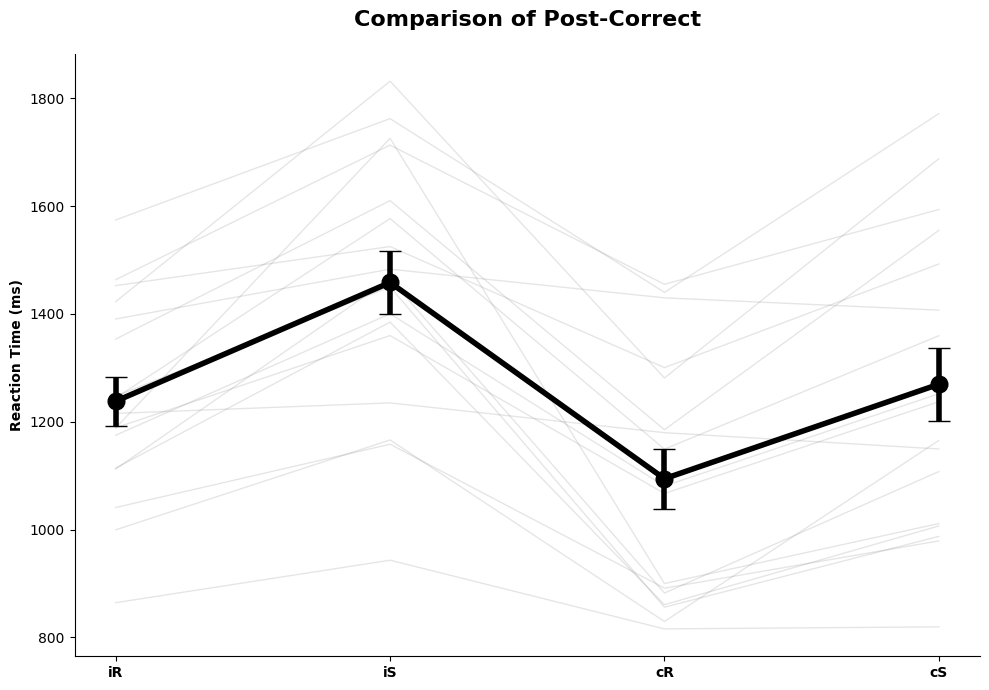

In [ ]:
# running plotting
my_dicts = [post_corr_iR_correct, post_corr_iS_correct, 
            post_corr_cR_correct, post_corr_cS_correct]

my_labels = ["iR", "iS", "cR", "cS"]

plot_four_way_comparison(df, my_dicts, my_labels, title="Comparison of Post-Correct")

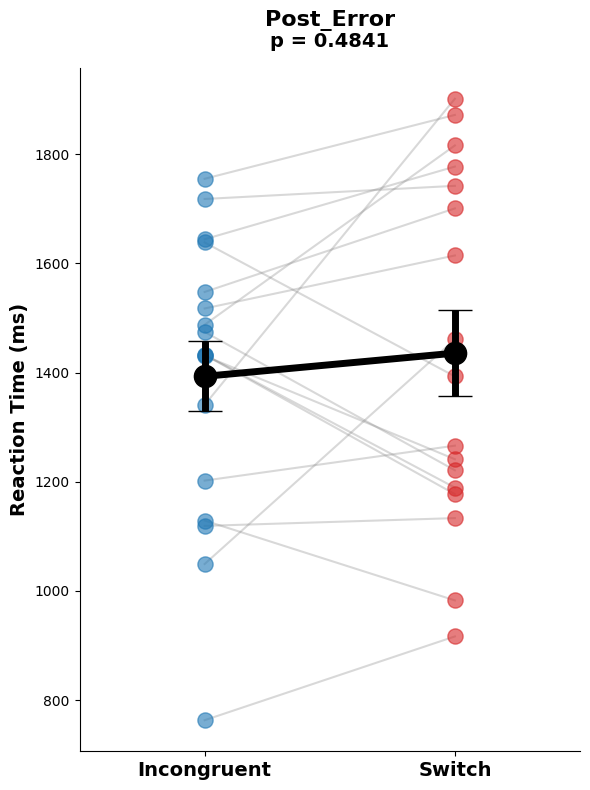

In [ ]:
#plot_results(results1, "Incongruent", "Switch", "Post_Stability_Errors")
#plot_results(results2, "Incongruent", "Switch", "Post_Flexibility_Errors")
#plot_results(results3, "Incongruent", "Switch", "Post_Stability_Correct")
#plot_results(results4, "Incongruent", "Switch", "Post_Flexibility_Correct")
#plot_results(results5, "Incongruent", "Switch", "Post_Error")
#plot_results(results6, "Incongruent", "Congruent", "Post_Error")